In [98]:
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
import numpy as np


import os


This simulation solves the bounce-averaged pure pitch-angle diffusion equation using the Crank-Nicolson method. All computations are done in Gaussian units.

In [99]:
# general sim parameters for t and a, important constants

N_alpha = 360
a = np.linspace(1E-8, np.pi/2-1E-8, num=N_alpha+1)  # avoid 0, pi/2 singularities
da = a[1]-a[0]

dt = 0.01
stop_time = 100      # should be a multiple of 5
t_range = np.linspace(0, stop_time, num=int(stop_time/dt)+1)


# constants
mec2 = 511000           # keV
me = 9.109E-28          # g
c = 29979245800         # cm/s
Bo = 0.312              # G
Re = 6371 * 1000 * 100  # cm


sina = np.sin(a)
sin2a = np.sin(2*a)
cosa = np.cos(a)
cos2a = np.cos(2*a)
Talpha = 1.3 - 0.56*sina
# dTda = np.ones(a.shape) * 0.56 * cosa

dirac90 = np.zeros(a.shape)
dirac90[-1] = 1/da
dirac90[-2] = 1/(2*da)



In [100]:
# particle conditions/characteristics

# B-field related
L_shell = 5   
a_L = np.asin(np.sqrt(1/L_shell**3 * 1/np.sqrt(4-3/L_shell)))   # radians

# particle energy related
E_k = 50000                 # keV
gam_rel = 1 + E_k/mec2
v = c * np.sqrt(1 - 1/(gam_rel)**2)     # cm/s

# characteristic loss timescale
t_L = Re * L_shell/v * Talpha    # s

heaviside_adaL = np.heaviside(a-a_L, np.zeros(a.shape))
dirac_adaL = np.zeros(a.shape)
dirac_adaL[round(a_L/da)] = 1/da

In [ ]:
# diffusion and simulation conditions

# diffusion coefficient as a function of a
Dstar = 0.003
Daa = np.ones(a.shape) * Dstar / np.cos((a-a_L)*heaviside_adaL)

# loss coefficient as a function of a
L = np.ones(a.shape) * 1/t_L * np.heaviside(-(a-a_L), np.ones(a.shape))

# source term as a function of a
S = 20 * dirac90

# distribution initial condition
f0 = 100 * cosa**2 * np.ones(a.shape)      # uniform distribution; counts/rad
N0 = sum(f0)                     # number of particles initially; if S=L=0, this should be conserved

# plt.plot(a, Daa)
# plt.show()


In [102]:
# solver outputs

save_frequency = 10      # save f for plotting every n seconds of simulation time
save_times = np.linspace(0, stop_time, num=int(stop_time/save_frequency)+1)
# print(save_times)
saved_f = np.zeros((len(a), len(save_times)))
steady_state = np.zeros(a.shape) 

N = np.zeros(t_range.shape)     # number of particles; saved at all simulation times

# output directory
RUN_NAME = "50keV_L5"
PLOTS_DIRECTORY = "plots/" + RUN_NAME + "/"
DATA_DIRECTORY = "data/" + RUN_NAME + "/"

if not os.path.exists(PLOTS_DIRECTORY) or not os.path.isdir(PLOTS_DIRECTORY):
    os.makedirs(PLOTS_DIRECTORY)

if not os.path.exists(DATA_DIRECTORY) or not os.path.isdir(DATA_DIRECTORY):
    os.makedirs(DATA_DIRECTORY)

time: 0.0		particles: 18049.999999999993


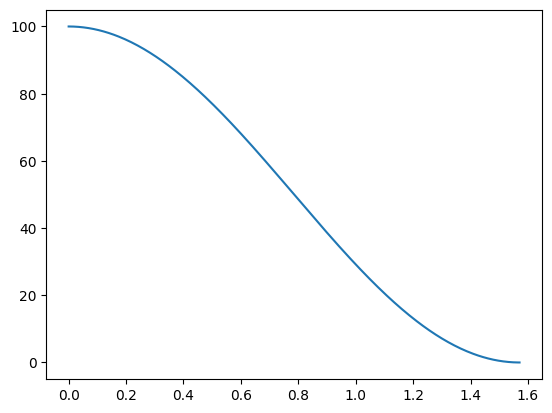

time: 10.0		particles: 17267.862424780873


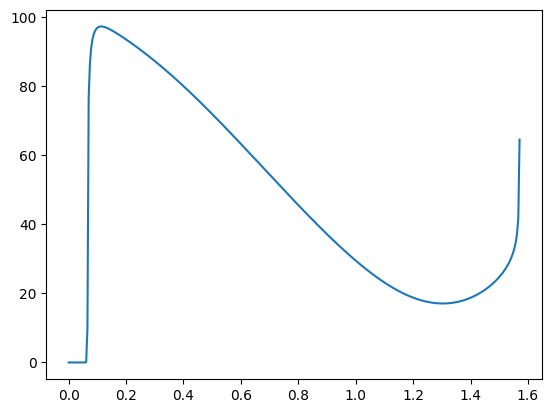

time: 20.0		particles: 17158.0919222377


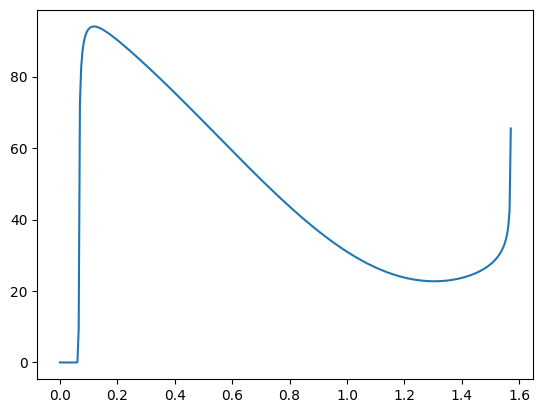

time: 30.0		particles: 16898.371706299567


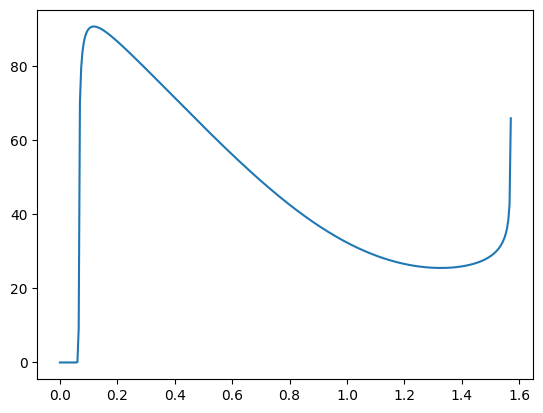

time: 40.0		particles: 16571.99750406589


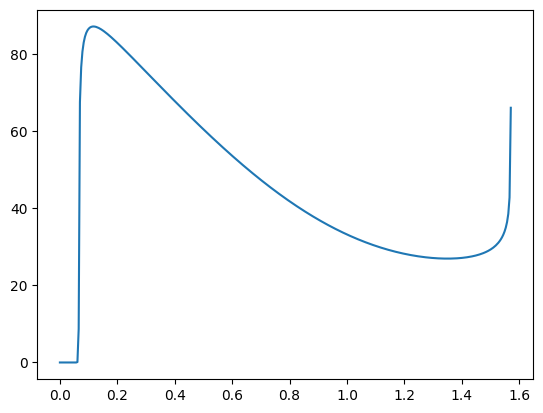

time: 50.0		particles: 16213.861813984831


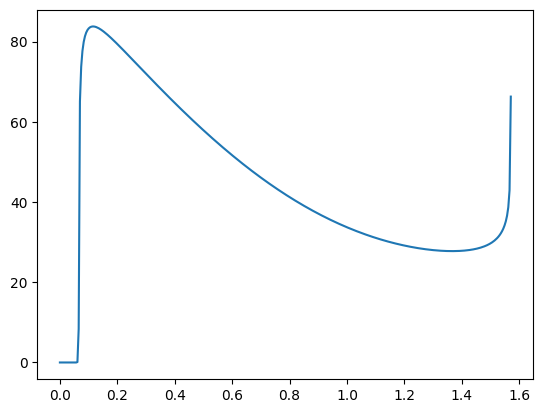

time: 60.0		particles: 15842.204569437365


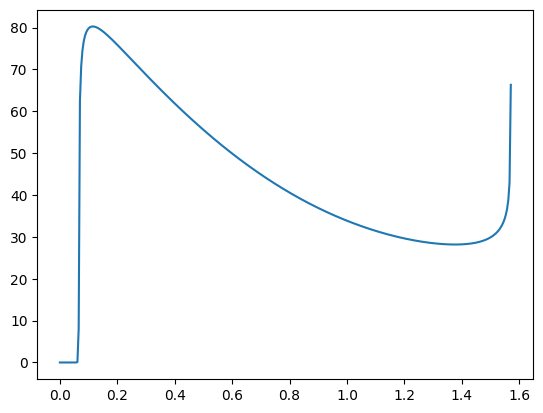

time: 70.0		particles: 15467.53036326415


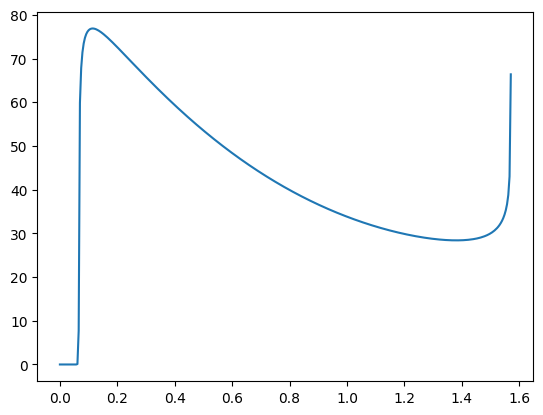

time: 80.0		particles: 15096.171257390299


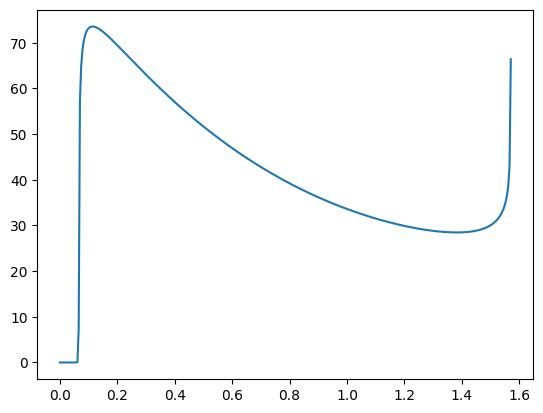

time: 90.0		particles: 14732.007978085112


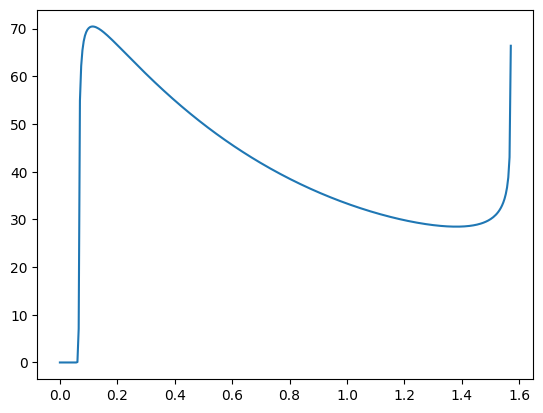

time: 100.0		particles: 14377.40603756427


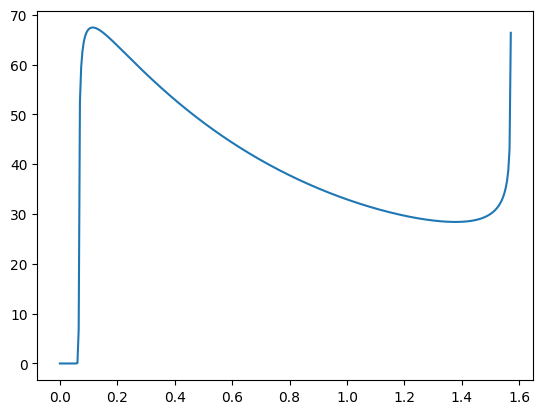

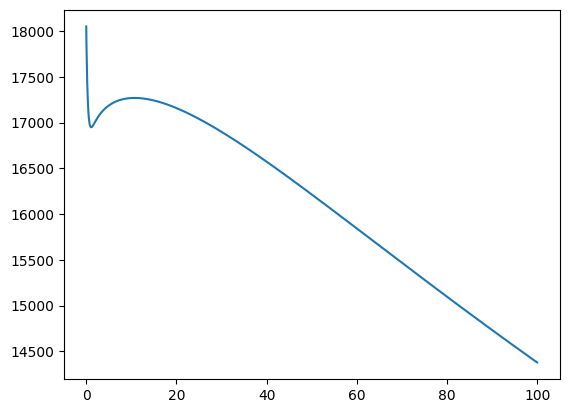

In [103]:
# set up and solve fat matrix inversions for each timestep

save_col = 0
f = f0
for time, i in zip(t_range, range(len(t_range))):
    N[i] = sum(f)
    if time in save_times:
        saved_f[:,save_col] = f     # save f @ t_n
        save_col = save_col + 1

        print(f"time: {np.round(time, decimals=5)}\t\tparticles: {N[i]}")

        # if time % 60 == 0:
        plt.plot(a,f)
        plt.show()
        
    # compute coefficients for each alpha
    A = np.zeros(a.shape)
    B = np.zeros(a.shape)
    C = np.zeros(a.shape)
    D = np.zeros(a.shape)
    K = np.zeros(a.shape)
    for alpha, j in zip(a, range(len(a))):
        if j == 0:      # boundary condition: df/da = 0 @ alpha = 0
            A[j] = 0 
            B[j] = -1/(4*da) # 1/dt + L[j]/2 + Daa[j]/(da**2)
            C[j] = 1/(4*da) # -K[j]/(16*da**2) - Daa[j]/(2*da**2) 
            D[j] = 0 # S[j]

            # D[j] = ((1/dt - L[j]/2 - Daa[j]/(da**2))*f[j] +
            #         (K[j]/(16*da**2) + Daa[j]/(2*da**2))*f[j+1]) + S[j]
                  
        elif j == len(a) - 1:       # boundary condition: df/da = 0 @ alpha = pi/2
            A[j] = -1/(4*da) # K[j-1]/(16*da**2) - Daa[j]/(2*da**2) 
            B[j] = 1/(4*da) # 1/dt + L[j]/2 + Daa[j]/(da**2)
            C[j] = 0 
            D[j] = 0 # S[j]
            # D[j] = ((-K[j-1]/(16*da**2) + Daa[j]/(2*da**2))*f[j-1] +
            #         (1/dt - L[j]/2 - Daa[j]/(da**2))*f[j]) + S[j]  
        else:
            K[j] = (sin2a[j+1]*Talpha[j+1]*Daa[j+1] - sin2a[j]*Talpha[j]*Daa[j]) / (sin2a[j]*Talpha[j])

            A[j] = K[j]/(16*da**2) - Daa[j]/(2*da**2)
            
            B[j] = 1/dt  + Daa[j]/(da**2)

            C[j] = -K[j]/(16*da**2) - Daa[j]/(2*da**2)

            D[j] = ((-K[j]/(16*da**2) + Daa[j]/(2*da**2))*f[j-1] +
                    (1/dt - L[j] - Daa[j]/(da**2))*f[j] +
                    (K[j]/(16*da**2) + Daa[j]/(2*da**2))*f[j+1]) + S[j] 

    # solve_banded and get f @ t_n+1
    inversion_matrix = np.vstack((C,B,A))

    # if time in save_times:
    # plt.plot(a, D)
    # plt.show()

    f = solve_banded((1,1), inversion_matrix, D)        # f at time n+1
    
plt.plot(t_range, N)
plt.show()